# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

### 1.1. Чтение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# прочитаем данные
users = pd.read_csv('Churn.csv')
users.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


У 10% клиентов нет значения признака Tenure. Разберемся с этим далее.

In [4]:
# проверим, есть ли полные дубликаты
users[users.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [5]:
# на всякий случай проверим, есть ли дубликаты по клиенту
users[users.duplicated(['CustomerId'])] 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [6]:
# уберем признаки, не влиюящие на целевую переменную - имя клиента, его айди и номер строки
users = users.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1)
users.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### 1.2. Предобработка признаков

In [7]:
# проведем one-hot-encoding
users = pd.get_dummies(users, drop_first=True)
users.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


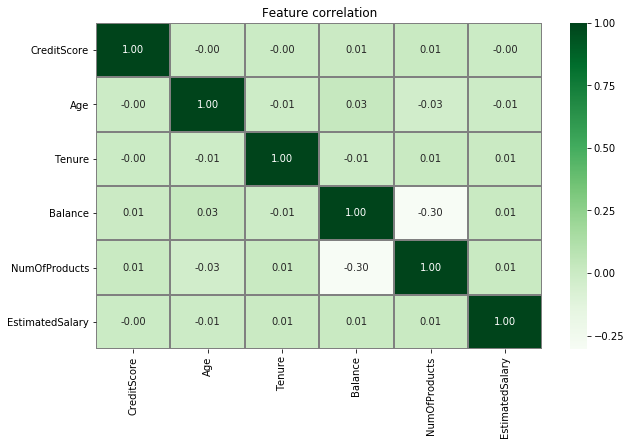

In [8]:
# проверим мультиколлинеарность признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cm = users[numeric].corr()
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="Greens")
ax.set_title('Feature correlation')
plt.show()

Итого: дубликатов нет, признаки практически не зависят друг от друга. Отлично.

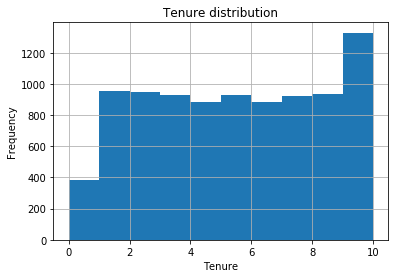

In [9]:
users['Tenure'].hist()
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.title('Tenure distribution')
plt.show()

Как мы убедились выше, признак Tenure не зависит от остальных признаков, а само значение признака распределено практически равномерно от 1 до 9 (а 0 и 10 взаимно уравновешивают друг друга). Поэтому просто заполним пропуски медианным значением.

In [10]:
users['Tenure'] = users['Tenure'].fillna(users['Tenure'].median())

In [11]:
X = users.drop('Exited', axis=1) # выделим признаки
y = users['Exited'] # выделим целевую переменную

# делим наблюдения на обучающую+валидационную и тестовую выборки
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# делим наблюдения на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=1, stratify=y_train_valid)
print(X_train.shape) # посмотрим на размеры выборок
print(X_valid.shape)
print(X_test.shape)

(6400, 11)
(1600, 11)
(2000, 11)


In [12]:
# масштабируем значения признаков
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])

### 1.3. Исследование баланса классов.

Проверим баланс классов.

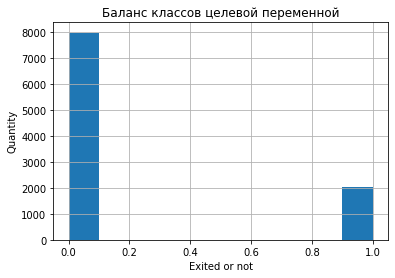

In [13]:
users['Exited'].hist()
plt.xlabel('Exited or not')
plt.ylabel('Quantity')
plt.title('Баланс классов целевой переменной')
plt.show()

In [14]:
users['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Как видим, наблюдается заметный дисбаланс: положительных наблюдений заметно меньше, чем отрицательных.

# 2. Исследование задачи

Создадим функцию, которая будет применять RandomizedSearchCV для DecisionTree и RandomForest и выводить целевые показатели.

In [15]:
param_tree = {'max_depth': range(5, 51, 5), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)}
param_forest = {'n_estimators': range(10, 101, 10)}

In [16]:
def model_with_randomizedsearchcv(model, features, target):
    model.fit(features, target)
    best_model = model.best_estimator_
    predictions = best_model.predict(X_valid)
    print('F1 = {:.3f}, а ROC-AUC = {:.3f}'.format(f1_score(y_valid, predictions), roc_auc_score(y_valid, predictions)))

Создадим функцию, которая будет выводить целевые показатели для LogisticRegression.

In [17]:
def no_randomizedsearchcv(model, features, target):
    model.fit(features, target)
    predictions = model.predict(X_valid)
    print('F1 = {:.3f}, а ROC-AUC = {:.3f}'.format(f1_score(y_valid, predictions), roc_auc_score(y_valid, predictions)))

In [18]:
# обучим модели на сырых данных
print('DecisionTreeClassifier')
model = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=1), param_distributions = param_tree, scoring='f1', random_state=1)
model_with_randomizedsearchcv(model, X_train, y_train)

print('RandomForestClassifier')
model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1), param_distributions = param_forest, scoring='f1', n_iter=5, random_state=1)
model_with_randomizedsearchcv(model, X_train, y_train)

print('LogisticRegression')
model = LogisticRegression(solver='liblinear', random_state=1)
no_randomizedsearchcv(model, X_train, y_train)

DecisionTreeClassifier
F1 = 0.561, а ROC-AUC = 0.711
RandomForestClassifier
F1 = 0.542, а ROC-AUC = 0.695
LogisticRegression
F1 = 0.307, а ROC-AUC = 0.586


#### Вывод: 

Наши результаты не дотягивают до целевого (0.59). Попробуем далее исправить это с помощью учёта дисбаланса классов.

# 3. Борьба с дисбалансом

Видим, что положительных ответов сильно меньше, чем отрицательных. Попробуем исправить это.

### 3.1. Взвешенные модели.

In [19]:
# сделаем модели взвешенными
print('Взвешенные модели:')
print('DecisionTreeClassifier')
model = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=1, class_weight='balanced'), param_distributions = param_tree, scoring='f1', random_state=1)
model_with_randomizedsearchcv(model, X_train, y_train)

print('RandomForestClassifier')
model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1, class_weight='balanced'), param_distributions = param_forest, scoring='f1', n_iter=5, random_state=1)
model_with_randomizedsearchcv(model, X_train, y_train)

print('LogisticRegression')
model = LogisticRegression(solver='liblinear', random_state=1, class_weight='balanced')
no_randomizedsearchcv(model, X_train, y_train)

Взвешенные модели:
DecisionTreeClassifier
F1 = 0.592, а ROC-AUC = 0.773
RandomForestClassifier
F1 = 0.548, а ROC-AUC = 0.697
LogisticRegression
F1 = 0.496, а ROC-AUC = 0.705


Применение взвешенных моделей улучшило наш результат.

### 3.2. Upsampling и downsampling.

In [20]:
# увеличим количество положительных ответов
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=1)
    
    return X_upsampled, y_upsampled

X_upsampled, y_upsampled = upsample(X_train, y_train, 10)

print('Увеличенная выборка:')
print('DecisionTreeClassifier')
model = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=1, class_weight='balanced'), param_distributions = param_tree, scoring='f1', random_state=1)
model_with_randomizedsearchcv(model, X_upsampled, y_upsampled)

print('RandomForestClassifier')
model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1, class_weight='balanced'), param_distributions = param_forest, scoring='f1', n_iter=5, random_state=1)
model_with_randomizedsearchcv(model, X_upsampled, y_upsampled)

print('LogisticRegression')
model = LogisticRegression(solver='liblinear', random_state=1, class_weight='balanced')
no_randomizedsearchcv(model, X_upsampled, y_upsampled)

Увеличенная выборка:
DecisionTreeClassifier
F1 = 0.494, а ROC-AUC = 0.681
RandomForestClassifier
F1 = 0.621, а ROC-AUC = 0.752
LogisticRegression
F1 = 0.496, а ROC-AUC = 0.705


In [21]:
# уменьшим количество отрицательных ответов
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat([X_zeros.sample(frac=fraction, random_state=1)] + [X_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=1)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=1)
    
    return X_downsampled, y_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.1)

print('Уменьшенная выборка:')
print('DecisionTreeClassifier')
model = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=1, class_weight='balanced'), param_distributions = param_tree, scoring='f1', random_state=1)
model_with_randomizedsearchcv(model, X_downsampled, y_downsampled)

print('RandomForestClassifier')
model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1, class_weight='balanced'), param_distributions = param_forest, scoring='f1', n_iter=5, random_state=1)
model_with_randomizedsearchcv(model, X_downsampled, y_downsampled)

print('LogisticRegression')
model = LogisticRegression(solver='liblinear', random_state=1, class_weight='balanced')
no_randomizedsearchcv(model, X_downsampled, y_downsampled)

Уменьшенная выборка:
DecisionTreeClassifier
F1 = 0.478, а ROC-AUC = 0.704
RandomForestClassifier
F1 = 0.484, а ROC-AUC = 0.719
LogisticRegression
F1 = 0.505, а ROC-AUC = 0.714


### 3.3. Поиск нужного порога.

Теперь попробуем найти наиболее адекватный порог.

In [22]:
# создадим функцию для проверки порога с использованием RandomizedSearchCV для DecisionTree и RandomForest
def model_with_randomizedsearchcv_threshold(model, features, target):
    model.fit(features, target)
    best_model = model.best_estimator_
    probabilities_valid = best_model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    for threshold in np.arange(0.1, 0.51, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(y_valid, predicted_valid)
        roc_auc = roc_auc_score(y_valid, predicted_valid)
        print("Порог = {:.2f} | F1 = {:.3f}| ROC-AUC = {:.3f}".format(threshold, f1, roc_auc))

In [23]:
print('DecisionTreeClassifier')
model = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=1, class_weight='balanced'), param_distributions = param_tree, scoring='f1', random_state=1)
model_with_randomizedsearchcv_threshold(model, X_train, y_train)

print('RandomForestClassifier')
model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1, class_weight='balanced'), param_distributions = param_forest, scoring='f1', n_iter=5, random_state=1)
model_with_randomizedsearchcv_threshold(model, X_train, y_train)

print('LogisticRegression')
model = LogisticRegression(solver='liblinear', random_state=1, class_weight='balanced')
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
    
for threshold in np.arange(0.1, 0.51, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    roc_auc = roc_auc_score(y_valid, predicted_valid)
    print("Порог = {:.2f} | F1 = {:.3f}| ROC-AUC = {:.3f}".format(threshold, f1, roc_auc))

DecisionTreeClassifier
Порог = 0.10 | F1 = 0.398| ROC-AUC = 0.612
Порог = 0.15 | F1 = 0.409| ROC-AUC = 0.630
Порог = 0.20 | F1 = 0.436| ROC-AUC = 0.667
Порог = 0.25 | F1 = 0.436| ROC-AUC = 0.667
Порог = 0.30 | F1 = 0.516| ROC-AUC = 0.743
Порог = 0.35 | F1 = 0.544| ROC-AUC = 0.761
Порог = 0.40 | F1 = 0.563| ROC-AUC = 0.769
Порог = 0.45 | F1 = 0.576| ROC-AUC = 0.770
Порог = 0.50 | F1 = 0.592| ROC-AUC = 0.773
RandomForestClassifier
Порог = 0.10 | F1 = 0.513| ROC-AUC = 0.743
Порог = 0.15 | F1 = 0.556| ROC-AUC = 0.770
Порог = 0.20 | F1 = 0.582| ROC-AUC = 0.768
Порог = 0.25 | F1 = 0.595| ROC-AUC = 0.764
Порог = 0.30 | F1 = 0.617| ROC-AUC = 0.761
Порог = 0.35 | F1 = 0.615| ROC-AUC = 0.752
Порог = 0.40 | F1 = 0.594| ROC-AUC = 0.730
Порог = 0.45 | F1 = 0.573| ROC-AUC = 0.715
Порог = 0.50 | F1 = 0.548| ROC-AUC = 0.697
LogisticRegression
Порог = 0.10 | F1 = 0.344| ROC-AUC = 0.512
Порог = 0.15 | F1 = 0.357| ROC-AUC = 0.541
Порог = 0.20 | F1 = 0.376| ROC-AUC = 0.577
Порог = 0.25 | F1 = 0.402| ROC-A

Лучший результат F1 - в районе порога 0.3.

# 4. Тестирование модели

In [24]:
# масштабируем данные
scaler = StandardScaler()
scaler.fit(X_train_valid[numeric])

X_train_valid[numeric] = scaler.transform(X_train_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

Создадим итоговую модель, используя наши лучшие наработки:
- RandomForestCLassifier как показавшую сравнительно лучший результат
- RandomizedSearchCV
- class_weight='balanced'
- порог около 0.3

1. Соберем модель с оптимальными параметрами и обучим ее на train.

In [29]:
# используем RandomizedSearchCV для RandomForestClassifier
model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1, class_weight='balanced'), param_distributions = param_forest, scoring='f1', n_iter=5, random_state=1)

model.fit(X_train, y_train)
best_model = model.best_estimator_
# подсчитаем вероятности
probabilities_valid = best_model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
# классифицируем вероятности с учётом порога
predicted_valid = probabilities_one_valid > 0.3
print('F1 модели RandomForestClassifier с порогом 0.3 - {:.3f}, а ROC-AUC - {:.3f}'.format(f1_score(y_valid, predicted_valid), roc_auc_score(y_valid, predicted_valid)))

F1 модели RandomForestClassifier с порогом 0.3 - 0.617, а ROC-AUC - 0.761


2. Результат удовлетворительный. Переобучим ту же самую модель на train+valid и проверим на test.

In [30]:
X_train_and_valid = pd.concat([X_train] + [X_valid])
y_train_and_valid = pd.concat([y_train] + [y_valid])

best_model.fit(X_train_and_valid, y_train_and_valid)

# подсчитаем вероятности
probabilities_test = best_model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
# классифицируем вероятности с учётом порога
predicted_test = probabilities_one_test > 0.3
print('F1 модели RandomForestClassifier с порогом 0.3 - {:.3f}, а ROC-AUC - {:.3f}'.format(f1_score(y_test, predicted_test), roc_auc_score(y_test, predicted_test)))

F1 модели RandomForestClassifier с порогом 0.3 - 0.601, а ROC-AUC - 0.753


Результат примерно такой же, модель работает удовлетворительно.

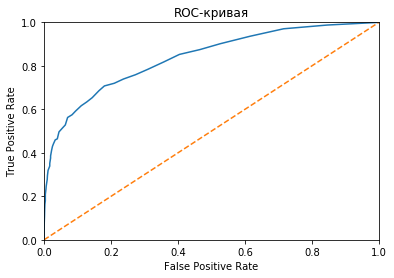

In [31]:
# построим график нашей roc-кривой итоговой "базовой" модели
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Вывод

На тестовой выборке наша модель показывает результат F1 больше целевого, а именно - 0.61. Задача выполнена.

### Общие выводы:
    
В ходе работы над задачей мы:

- провели предобработку данных, убедившись в отсутствии пропусков и дубликатов
- исследовали признаки, оставив только необходимые, провели one hot encoding и проверили мультиколлинеарность
- обнаружив дисбаланс классов, постарались смягчить его воздействие, равномерно распределив классы по выборкам, создав взвешенные модели, увеличивая количество положительных ответов в обучающей выборке и уменьшая количество отрицательных и настраивая порог классификации
- измеряли показатели F1 и ROC-AUC у наших моделей
- применяя вышеуказанные аспекты, построили итоговую модель, целевая метрика F1 которой превышает заданный порог (0.611 > 0.59).